In [459]:
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from celerite.modeling import Model, ConstantModel
import muhz2days

In [498]:
del pool

In [499]:
from multiprocessing import Pool
pool = Pool()

/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/ipykernel

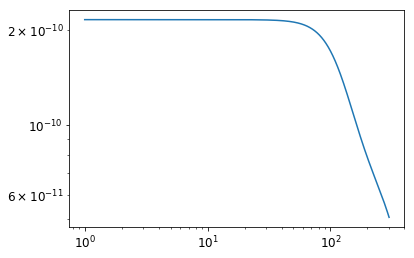

In [460]:
muhzconv = 1e6 / (3600*24)

def muhz2idays(muhz):
    return muhz / muhzconv

def muhz2omega(muhz):
    return muhz2idays(muhz) * 2.0 * np.pi

def idays2muhz(idays):
    return idays * muhzconv

def omega2muhz(omega):
    return idays2muhz(omega / (2.0 * np.pi))

omega = np.linspace(1, 300, 1000)
freqmuhz = omega2muhz(omega)
freqidays = muhz2idays(freqmuhz)
plt.loglog(omega, kernel.get_psd(omega));

In [461]:
data = np.loadtxt('/Users/samuelgrunblatt/Desktop/quicklook/211351816.dat.ts')
log_numax = np.log(200)
log_dnu = np.log(17.)

In [462]:
class ASTerm(terms.SHOTerm):
    parameter_names = ("log_numax", "log_dnu", "gamma_0", "gamma_1", "log_H0", "log_H1", "log_sigma", "log_Q")
    def get_all_coefficients(self, params=None):
        if params is None:
            params = self.get_parameter_vector(include_frozen=True)
        log_numax, log_dnu, gamma_0, gamma_1, log_H0, log_H1, log_sigma, log_Q = params
        gamma = np.array([gamma_0, gamma_1])
        H = np.exp([log_H0, log_H1])
        nunl, ampnl = self.modelfreq(np.exp(log_numax), np.exp(log_dnu), gamma, H, np.exp(log_sigma))
        coeffs = []
        for j in range(nunl.size):
            nu, amp = nunl.flat[j], ampnl.flat[j]
            log_S0 = np.log(amp)-2*log_Q
            log_omega = np.log(2*np.pi*nu)
            coeffs.append(super(ASTerm,self).get_all_coefficients([log_S0, log_Q, log_omega]))
        return [np.concatenate(args) for args in zip(*coeffs)]
        
    def modelfreq(self, numax, dnu, gammas, Hs, sigma):
        nprime = np.arange(-2,3,1)
        l = np.arange(len(gammas))
        nunl= numax + gammas[None,:] + (dnu * (nprime[:,None] + l[None,:]/2.))
        Anl = Hs[None,:]*np.exp(-(nunl - numax)**2/(2*sigma**2))
        return nunl, Anl

In [463]:
log_var = np.log(np.var(data[:, 1]))
k1 = ASTerm(
    log_numax=log_numax,
    log_dnu=log_dnu,
    gamma_0=0.0,
    gamma_1=0.0,
    log_H0=log_var,
    log_H1=log_var,
    log_sigma=np.log(10.0),
    log_Q=8.
)

k1.freeze_all_parameters()

k2 = terms.SHOTerm(log_Q=-0.5*np.log(2), log_S0=log_var, log_omega0=np.log(100))
k2.freeze_parameter("log_Q")

k3 = terms.SHOTerm(log_Q=-0.5*np.log(2), log_S0=log_var, log_omega0=np.log(150))
k3.freeze_parameter("log_Q")

k4 = terms.JitterTerm(0.5*log_var)

kernel = k1 + k2 + k3 + k4

In [464]:
kernel.coefficients

[array([], dtype=float64),
 array([], dtype=float64),
 array([  7.86188416e-11,   1.03618227e-09,   6.61509707e-09,
          2.04607032e-08,   3.06669548e-08,   2.22770580e-08,
          7.84413150e-09,   1.33902064e-09,   1.10824150e-10,
          4.44764752e-12,   5.14400814e-06,   7.71601221e-06]),
 array([  1.31868418e-14,   1.73800215e-13,   1.10955894e-12,
          3.43190067e-12,   5.14380870e-12,   3.73656026e-12,
          1.31570650e-12,   2.24595694e-13,   1.85886806e-14,
          7.46009772e-16,   5.14400814e-06,   7.71601221e-06]),
 array([   0.17494523,    0.18390327,    0.19286131,    0.20181935,
           0.21077739,    0.21973542,    0.22869346,    0.2376515 ,
           0.24660954,    0.25556758,   70.71067812,  106.06601718]),
 array([ 1043.00874632,  1096.41582068,  1149.82289504,  1203.2299694 ,
         1256.63704376,  1310.04411812,  1363.45119248,  1416.85826684,
         1470.2653412 ,  1523.67241556,    70.71067812,   106.06601718])]

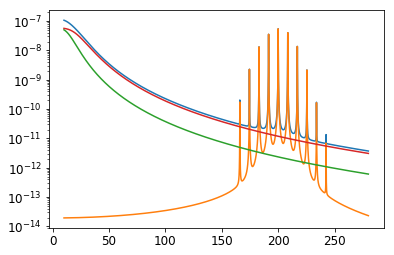

In [465]:
freq_muHz = np.linspace(10, 280, 10000)
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [466]:
time,flux = np.array(data[:,0])*0.0864, np.array(data[:,1])

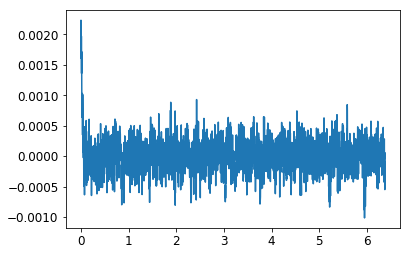

In [467]:
plt.plot(time,flux)

In [468]:
gp = celerite.GP(kernel)
gp.compute(time)

In [469]:
def nll(params):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(flux)

In [470]:
from scipy.optimize import minimize

soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -23423.238792842174
 hess_inv: array([[  3.52908391e-02,  -2.68740125e-02,   2.56967895e-02,
         -1.08887064e-02,  -1.20169298e-04],
       [ -2.68740125e-02,   2.13233433e-02,  -2.04667263e-02,
          8.74764119e-03,   9.47660643e-05],
       [  2.56967895e-02,  -2.04667263e-02,   2.16743073e-02,
         -8.63118896e-03,  -5.13764901e-04],
       [ -1.08887064e-02,   8.74764119e-03,  -8.63118896e-03,
          5.45767252e-03,  -3.09312840e-04],
       [ -1.20169298e-04,   9.47660643e-05,  -5.13764901e-04,
         -3.09312840e-04,   4.29172655e-04]])
      jac: array([-0.00366211, -0.00341797,  0.00732422,  0.00146484,  0.00097656])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 641
      nit: 28
     njev: 90
   status: 2
  success: False
        x: array([-21.12102347,   3.83853339, -23.1424231 ,   5.94807034,  -8.70504927])

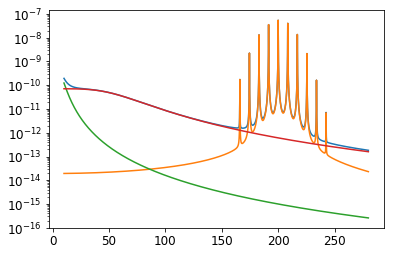

In [471]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

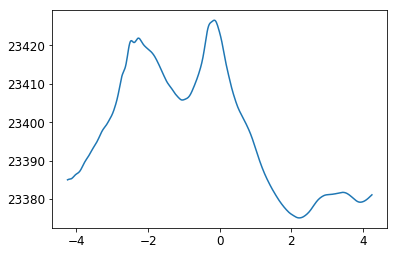

In [472]:
gammagrid = np.linspace(-0.25*np.exp(log_dnu),0.25*np.exp(log_dnu), 500)
like = np.empty_like(gammagrid)
for i,gamma in enumerate(gammagrid):
    k1.set_parameter("gamma_1", gamma)
    like[i] = gp.log_likelihood(flux)
best = gammagrid[np.argmax(like)]
k1.set_parameter("gamma_1", best)
plt.plot(gammagrid,like)

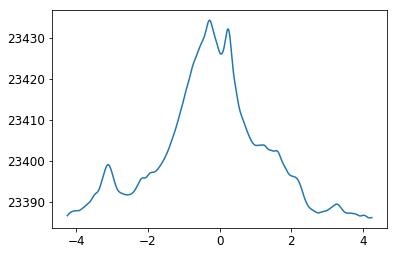

In [473]:
gammagrid = np.linspace(-0.25*np.exp(log_dnu),0.25*np.exp(log_dnu), 500)
like = np.empty_like(gammagrid)
for i,gamma in enumerate(gammagrid):
    k1.set_parameter("gamma_0", gamma)
    like[i] = gp.log_likelihood(flux)
best = gammagrid[np.argmax(like)]
k1.set_parameter("gamma_0", best)
plt.plot(gammagrid,like)

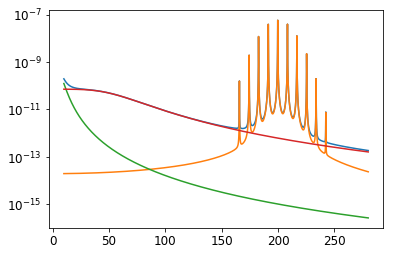

In [474]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [475]:
k1.thaw_parameter("gamma_0")
k1.thaw_parameter("gamma_1")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -23434.36624385942
 hess_inv: array([[  1.63379968e-03,  -1.01599729e-03,   2.02415310e-02,
         -1.05014540e-02,  -3.68924560e-04,   1.53398735e-04,
          1.53682342e-04],
       [ -1.01599729e-03,   6.68222707e-03,  -7.27175860e-02,
          3.59460841e-02,   5.06387004e-03,  -2.64648255e-03,
         -2.90601946e-04],
       [  2.02415310e-02,  -7.27175860e-02,   1.51968496e+00,
         -7.68811061e-01,  -8.28501970e-02,   3.48175463e-02,
          1.08195911e-02],
       [ -1.05014540e-02,   3.59460841e-02,  -7.68811061e-01,
          3.97652062e-01,   3.93893334e-02,  -1.74354635e-02,
         -5.17714277e-03],
       [ -3.68924560e-04,   5.06387004e-03,  -8.28501970e-02,
          3.93893334e-02,   6.13104977e-03,  -1.85498316e-03,
         -8.34063637e-04],
       [  1.53398735e-04,  -2.64648255e-03,   3.48175463e-02,
         -1.74354635e-02,  -1.85498316e-03,   2.37842204e-03,
         -3.87329229e-05],
       [  1.53682342e-04,  -2.90601946e-04,   1.08195

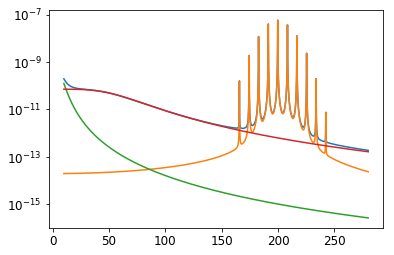

In [476]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [477]:
k1.thaw_parameter("log_H0")
k1.thaw_parameter("log_H1")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -23516.377513834683
 hess_inv: array([[  1.33650916e+00,   3.27398406e-01,   3.36502725e-01,
         -2.23046715e-01,   1.48216778e-01,   1.06143326e+01,
          7.86035152e-02,  -3.06814988e-02,   3.15444034e-03],
       [  3.27398406e-01,   8.09754855e-02,   8.21698323e-02,
         -5.38614757e-02,   3.65490592e-02,   2.60205028e+00,
          1.90379309e-02,  -7.45833494e-03,   7.58919754e-04],
       [  3.36502725e-01,   8.21698323e-02,   8.75454097e-02,
         -6.10467036e-02,   3.50655987e-02,   2.66907468e+00,
          1.85934536e-02,  -6.98956773e-03,   6.76551922e-04],
       [ -2.23046715e-01,  -5.38614757e-02,  -6.10467036e-02,
          9.79586719e-02,  -2.07154397e-04,  -1.77989755e+00,
         -1.97630275e-02,   7.35862303e-03,  -7.38008665e-04],
       [  1.48216778e-01,   3.65490592e-02,   3.50655987e-02,
         -2.07154397e-04,   3.34387198e-02,   1.17522870e+00,
          3.79549369e-03,  -5.06814500e-04,  -1.56000969e-04],
       [  1.06143326e+0

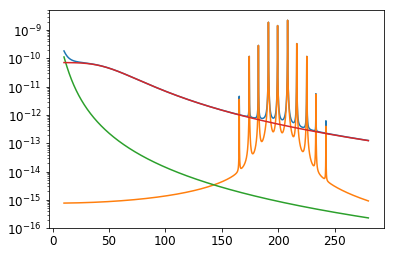

In [478]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

      fun: -23516.90358017822
 hess_inv: array([[  6.25786291e-04,   1.81722288e-05,  -6.25572488e-06,
         -6.10145520e-04,   1.87811007e-04,  -1.05882266e-05,
          8.84922549e-05,   9.19731636e-05,  -7.62140746e-05,
          1.61610334e-05],
       [  1.81722288e-05,   2.91178423e-04,   1.58115936e-04,
          1.50397032e-05,  -3.96131612e-04,  -4.44353776e-04,
          2.42855907e-04,   1.47000722e-04,  -2.92895364e-04,
          3.92848929e-05],
       [ -6.25572488e-06,   1.58115936e-04,   1.14048669e-02,
         -1.32133852e-02,   3.14185330e-03,  -3.62430210e-03,
          1.68803617e-03,  -3.28619355e-03,  -2.28072289e-03,
          7.62648819e-04],
       [ -6.10145520e-04,   1.50397032e-05,  -1.32133852e-02,
          3.40548628e-02,  -1.76113076e-02,  -3.84480377e-03,
         -3.21122636e-03,   5.07935922e-03,  -3.48910211e-04,
         -7.76310290e-04],
       [  1.87811007e-04,  -3.96131612e-04,   3.14185330e-03,
         -1.76113076e-02,   1.59237765e-02,  

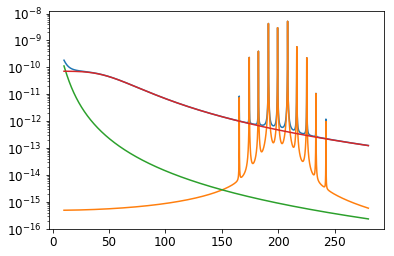

In [479]:
k1.thaw_parameter("log_Q")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

      fun: -23531.25860461104
 hess_inv: array([[  1.49796611e-03,   1.50436191e-03,  -1.09339877e-03,
         -1.40593131e-04,  -3.51198875e-04,  -9.28161010e-04,
         -1.39898056e-03,  -3.71360792e-04,  -1.16042031e-03,
          1.29658170e-04,  -4.77408817e-04],
       [  1.50436191e-03,   2.84891495e-03,  -1.65521752e-03,
          1.46068762e-04,  -1.02985103e-04,  -2.72768486e-03,
         -2.38291502e-03,  -6.58425074e-04,  -3.21535880e-03,
          1.15457904e-03,  -6.33620063e-04],
       [ -1.09339877e-03,  -1.65521752e-03,   2.70086522e-03,
         -3.11865571e-04,  -9.53464994e-05,   7.20390766e-04,
          9.33671034e-04,  -2.13752855e-04,   1.32062312e-03,
         -2.76354920e-05,   5.68627087e-05],
       [ -1.40593131e-04,   1.46068762e-04,  -3.11865571e-04,
          1.26809266e-03,   1.17791324e-04,   3.05436939e-04,
         -3.10351923e-04,   1.46562867e-03,   1.88222910e-03,
         -1.02604223e-03,   2.83267969e-04],
       [ -3.51198875e-04,  -1.02985

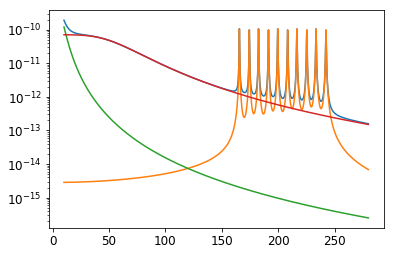

In [480]:
k1.thaw_parameter("log_sigma")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

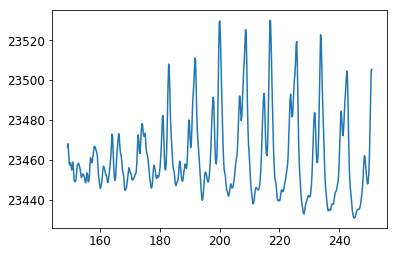

In [481]:
numaxgrid = np.linspace(-3*np.exp(log_dnu),3*np.exp(log_dnu), 500)+np.exp(log_numax)
like = np.empty_like(numaxgrid)
for i,numax in enumerate(numaxgrid):
    k1.set_parameter("log_numax", np.log(numax))
    like[i] = gp.log_likelihood(flux)
best = numaxgrid[np.argmax(like)]
k1.set_parameter("log_numax", np.log(best))
plt.plot(numaxgrid,like)

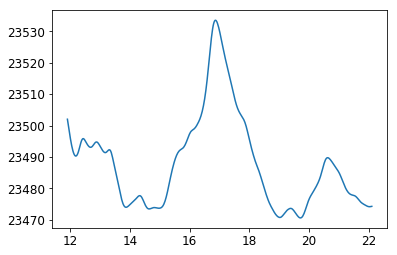

In [482]:
dnugrid = np.linspace(-0.3*np.exp(log_dnu),0.3*np.exp(log_dnu), 500)+np.exp(log_dnu)
like = np.empty_like(dnugrid)
for i,dnu in enumerate(dnugrid):
    k1.set_parameter("log_dnu", np.log(dnu))
    like[i] = gp.log_likelihood(flux)
best = dnugrid[np.argmax(like)]
k1.set_parameter("log_dnu", np.log(best))
plt.plot(dnugrid,like)

      fun: -23552.909498857636
 hess_inv: array([[  1.20793422e-05,  -8.39850223e-07,  -2.65830583e-03,
         -2.63610042e-03,   2.36235475e-03,   3.91135763e-03,
          5.77168638e-07,   3.84624675e-03,  -1.01939337e-03,
          2.87641701e-04,   1.94846632e-04,  -9.79771891e-05,
          4.10732525e-05],
       [ -8.39850223e-07,   3.58775634e-07,   1.81678746e-04,
          1.81051975e-04,  -1.30657587e-04,  -3.20378683e-04,
         -1.06554558e-05,  -3.25167500e-04,   1.04666426e-04,
         -2.25353893e-05,  -2.18720784e-05,   1.03486863e-05,
         -4.22275531e-06],
       [ -2.65830583e-03,   1.81678746e-04,   5.85208173e-01,
          5.80181531e-01,  -5.20111564e-01,  -8.61022622e-01,
         -5.72806868e-05,  -8.47025337e-01,   2.24506128e-01,
         -6.34269015e-02,  -4.28231849e-02,   2.15175861e-02,
         -9.03630734e-03],
       [ -2.63610042e-03,   1.81051975e-04,   5.80181531e-01,
          5.75438009e-01,  -5.16715396e-01,  -8.53309852e-01,
         

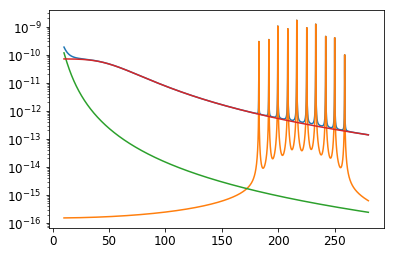

In [504]:
k1.thaw_all_parameters()
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [505]:
from astropy.stats import LombScargle

model = LombScargle(time, flux)
power = model.power(freq_muHz)

ERROR: TypeError: '<=' not supported between instances of 'module' and 'module' [numpy.core._methods]
ERROR:astropy:TypeError: '<=' not supported between instances of 'module' and 'module'


TypeError: '<=' not supported between instances of 'module' and 'module'

(0.0003, 0.01)

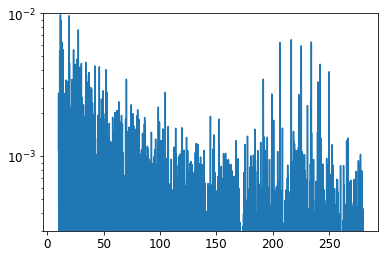

In [506]:
plt.semilogy(freq_muHz, power)
plt.ylim(3e-4,1e-2)

In [529]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_numax', 5.3863393990783486),
             ('kernel:terms[0]:log_dnu', 2.822688946234917),
             ('kernel:terms[0]:gamma_0', -1.918332674677562),
             ('kernel:terms[0]:gamma_1', -1.4786382865611432),
             ('kernel:terms[0]:log_H0', -19.799478614260046),
             ('kernel:terms[0]:log_H1', -19.965374246313761),
             ('kernel:terms[0]:log_sigma', 2.9351194357871755),
             ('kernel:terms[0]:log_Q', 9.0097699654802543),
             ('kernel:terms[1]:log_S0', -21.104266336810699),
             ('kernel:terms[1]:log_omega0', 3.8150866014234905),
             ('kernel:terms[2]:log_S0', -23.141950759493888),
             ('kernel:terms[2]:log_omega0', 5.9141201093881186),
             ('kernel:terms[3]:log_sigma', -8.6703094415824218)])

In [530]:
def lnprob(params):
    gp.set_parameter_vector(params)
    
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    elif params[7] > 15.0 or params[6] > 8.0:
        return -np.inf
    
    ll = gp.log_likelihood(flux)
    if not np.isfinite(ll):
        return -np.inf
    return ll + lp 
        
# Set up the sampler.
import emcee
#import triangleedit
import time


merged_par = gp.get_parameter_vector()

from matplotlib.ticker import MaxNLocator
ndim, nwalkers = len(merged_par), 30
pos = [merged_par *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 3000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 300

MCMC step runtime (in seconds): 0.09179186820983887
        MCMC estimated total runtime (in seconds): 275.3756046295166
        Start time: Tue, 27 Feb 2018 14:50:27
        
Running MCMC...
Done.
End time: Tue, 27 Feb 2018 14:52:52


In [531]:
best_pars_so_far = sampler.flatchain[np.argmax(sampler.flatlnprobability)]

pos = [best_pars_so_far *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 3000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC with best pars so far...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 300

MCMC step runtime (in seconds): 0.10338687896728516
        MCMC estimated total runtime (in seconds): 310.16063690185547
        Start time: Tue, 27 Feb 2018 14:52:52
        
Running MCMC with best pars so far...
Done.
End time: Tue, 27 Feb 2018 14:55:21


In [532]:
best_pars_so_far = sampler.flatchain[np.argmax(sampler.flatlnprobability)]

pos = [best_pars_so_far *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 3000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC with best pars so far...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 300

MCMC step runtime (in seconds): 0.10379791259765625
        MCMC estimated total runtime (in seconds): 311.39373779296875
        Start time: Tue, 27 Feb 2018 14:55:21
        
Running MCMC with best pars so far...
Done.
End time: Tue, 27 Feb 2018 14:57:53


In [533]:
[log_numax_mcmc, log_dnu_mcmc, gamma0_mcmc, gamma1_mcmc, log_H0_mcmc, \
    log_H1_mcmc, log_sigma_mcmc, log_Q0_mcmc, log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_jit] = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, [16, 50, 84], axis=0))) 
print("""MCMC result:
numax = {0[0]} +{0[1]} -{0[2]} 
dnu = {1[0]} +{1[1]} -{1[2]}
gamma0 = {2[0]} +{2[1]} -{2[2]} 
gamma1 = {3[0]} +{3[1]} -{3[2]}
log_H0 = {4[0]} +{4[1]} -{4[2]} 
log_H1 = {5[0]} +{5[1]} -{5[2]}
log_sigma = {6[0]} +{6[1]} -{6[2]}
log_Q0 = {7[0]} +{7[1]} -{7[2]} 
log_S0,0 = {8[0]} +{8[1]} -{8[2]}
log_omega0,0 = {9[0]} +{9[1]} -{9[2]}
log_S0,1 = {10[0]} +{10[1]} -{10[2]}
log_omega0,1 = {11[0]} +{11[1]} -{11[2]}
log_whitenoise = {12[0]} +{12[1]} -{12[2]}
""".format(np.exp(log_numax_mcmc), np.exp(log_dnu_mcmc), gamma0_mcmc, gamma1_mcmc, log_H0_mcmc, \
    log_H1_mcmc, log_sigma_mcmc, log_Q0_mcmc, log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_jit)) 
#lnper = {8[0]} +{8[1]} -{8[2]} 

print("Mean acceptance fraction: {0:.3f}"
        .format(np.mean(sampler.acceptance_fraction)))

MCMC result:
numax = 218.42343473778578 +1.0766728656045226 -1.0066516837581947 
dnu = 16.822287467595718 +1.0009759998845855 -1.001077924451502
gamma0 = -1.9182976519678832 +0.9179616404968933 -0.43377113082877994 
gamma1 = -1.4771052236117836 +0.896747993679126 -0.4247817591672103
log_H0 = -19.79252611868134 +0.6507174463340597 -0.8202334333897703 
log_H1 = -20.004875912903238 +0.725355679197822 -0.9883694160316736
log_sigma = 2.9196435837465318 +0.31371976013101044 -0.14223674671242081
log_Q0 = 8.968434654176601 +0.5621170622007146 -0.6900835821024636 
log_S0,0 = -21.11987854007246 +0.2700863438778107 -0.2475989033668391
log_omega0,0 = 3.8126003436693696 +0.14094153900419437 -0.14520042506535136
log_S0,1 = -23.15139805366803 +0.15669101629588056 -0.15560189025876525
log_omega0,1 = 5.906435113014828 +0.09122172952258722 -0.09274989312659354
log_whitenoise = -8.668605021357454 +0.027670479672073256 -0.02529398103675007

Mean acceptance fraction: 0.199


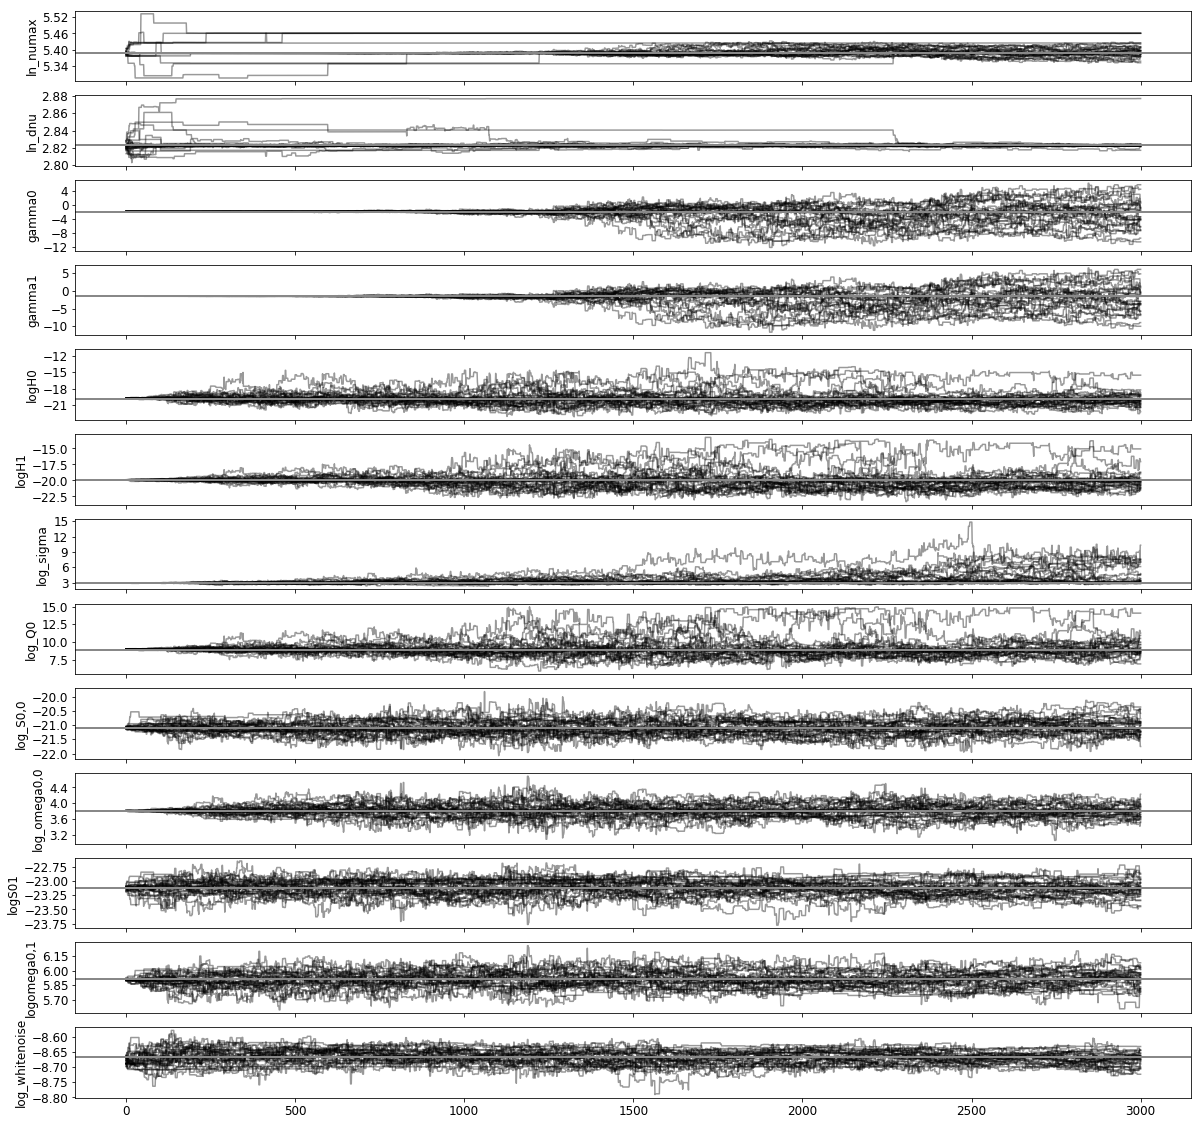

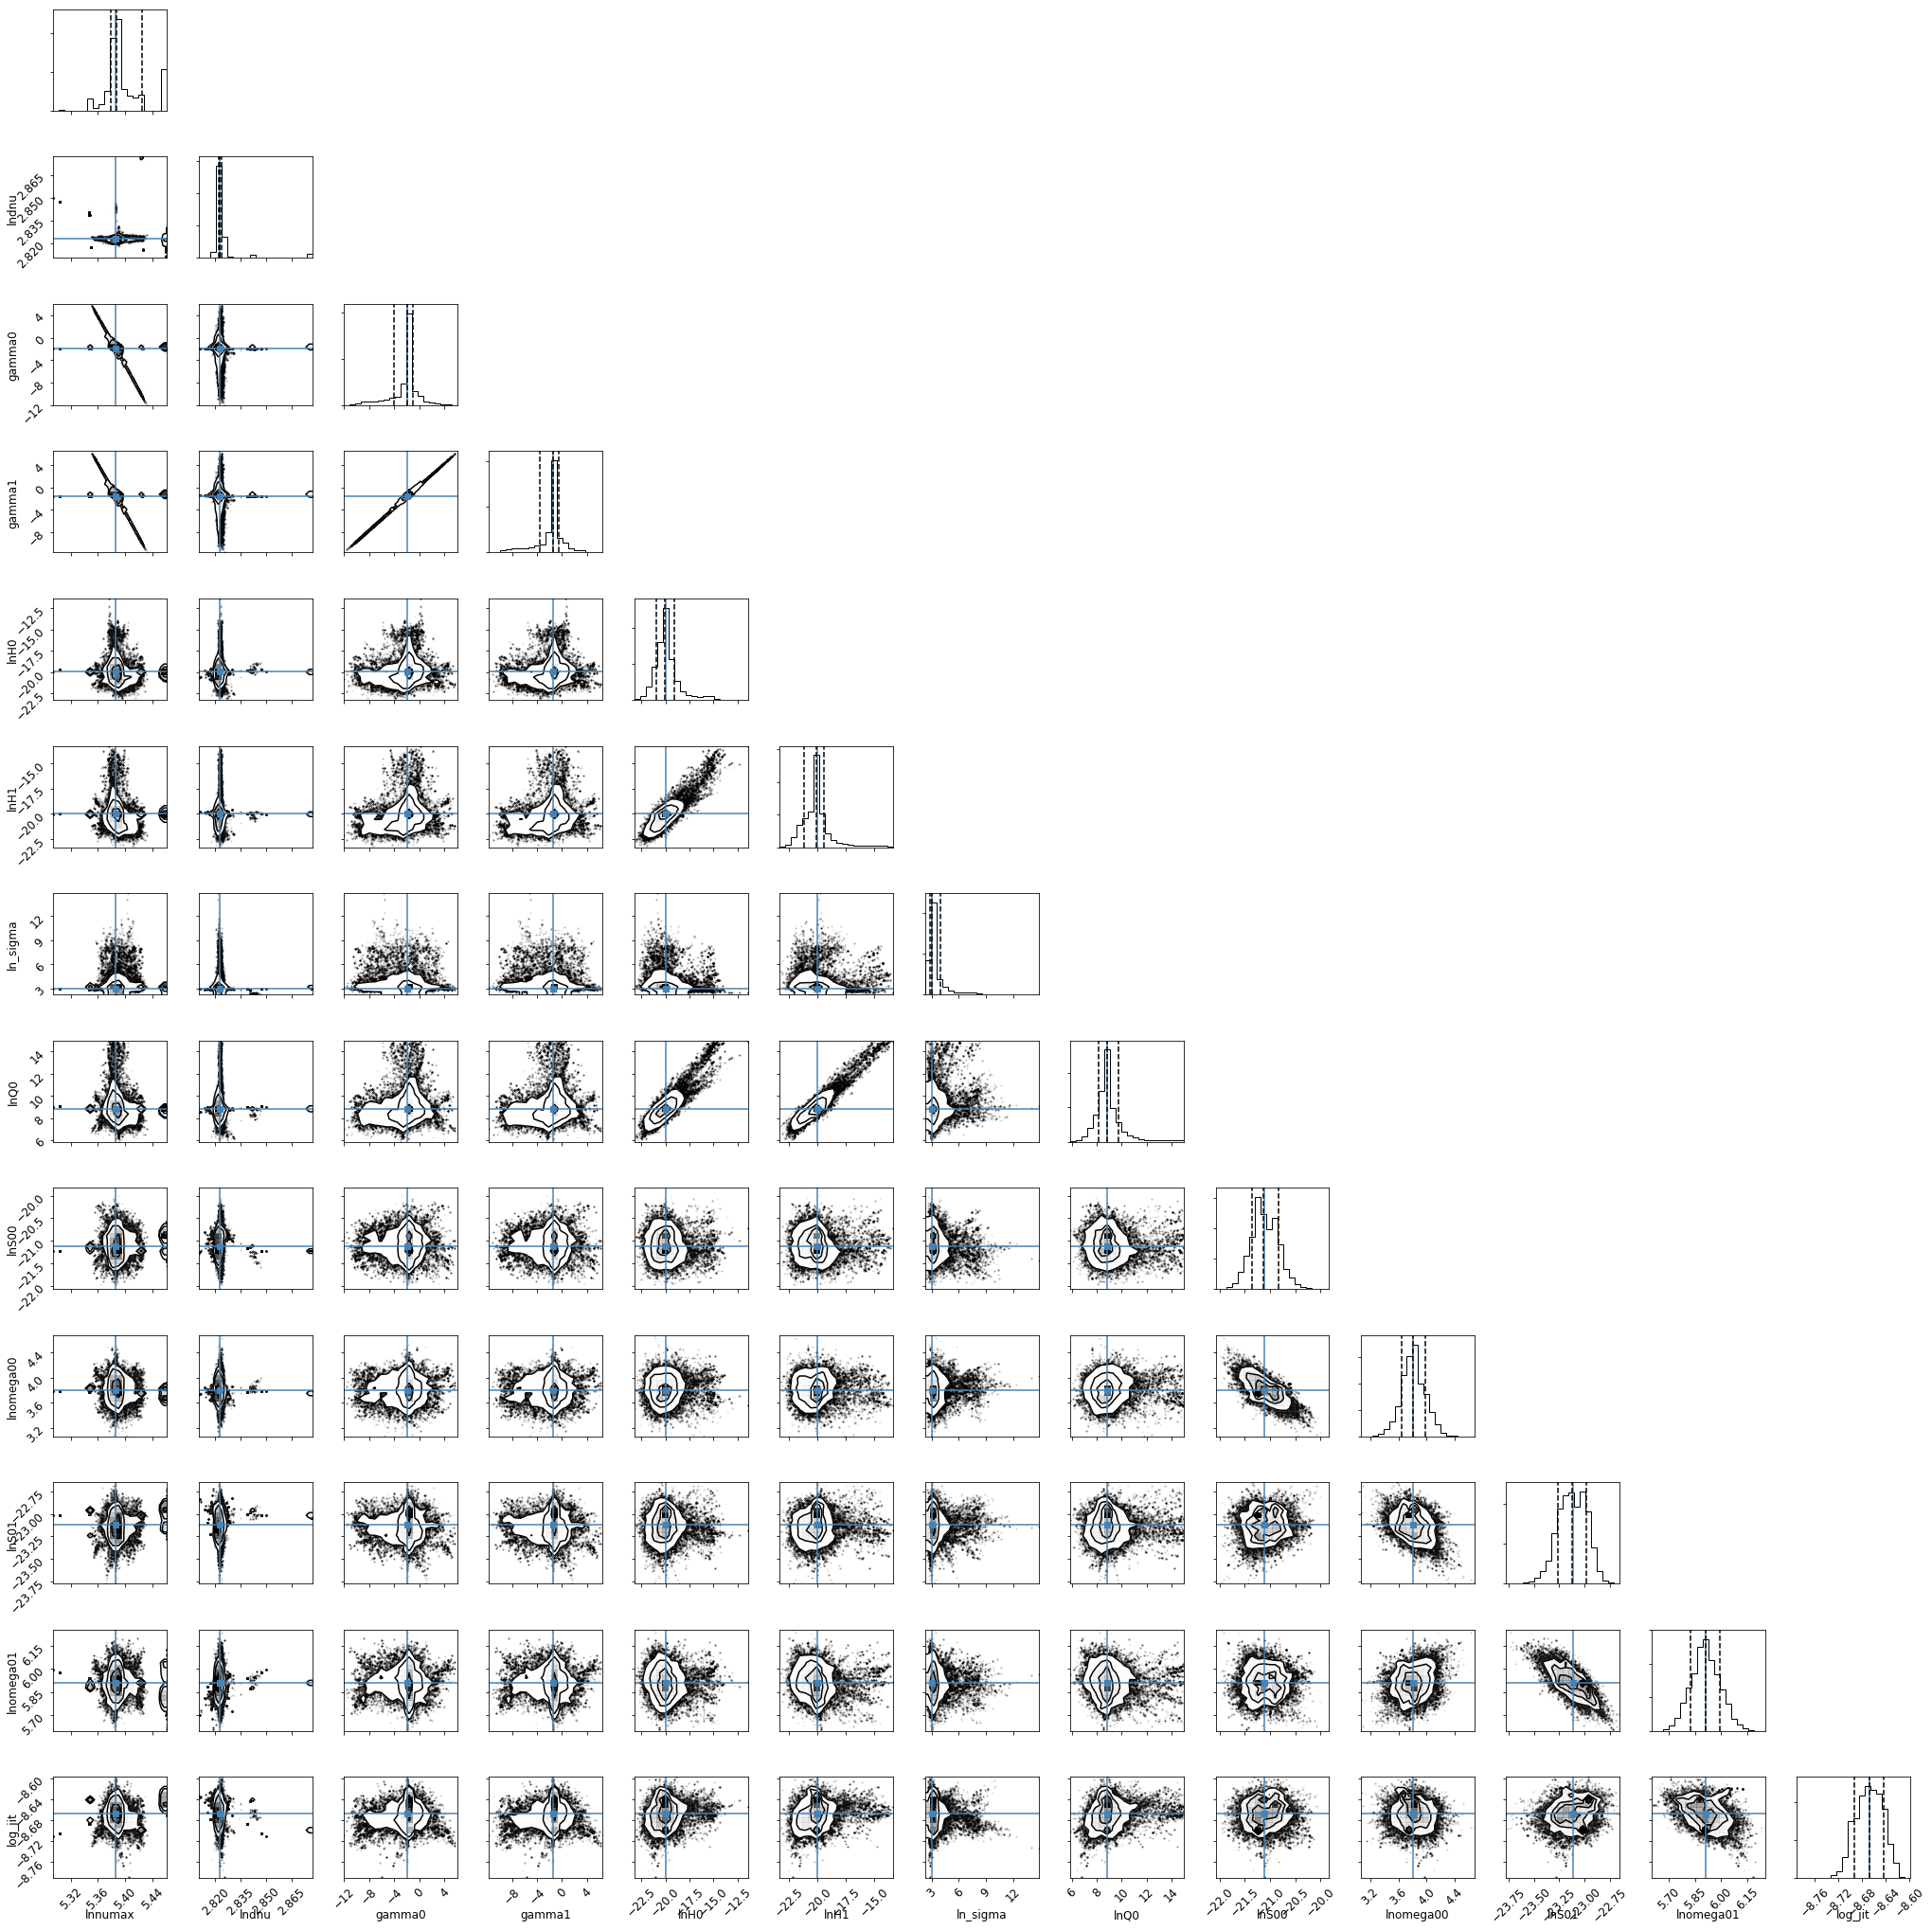

In [534]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

plt.clf()
fig, axes = plt.subplots(len(merged_par), 1, sharex=True, figsize=(20, 20))
axes[0].plot((sampler.chain[:, :, 0].T), color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(np.median(sampler.chain[:, :, 0].T), color="#888888", lw=2)
axes[0].set_ylabel(r"ln_numax")
    
axes[1].plot((sampler.chain[:, :, 1].T), color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(np.median(sampler.chain[:, :, 1].T), color="#888888", lw=2)
axes[1].set_ylabel(r"ln_dnu")

axes[2].plot((sampler.chain[:, :, 2].T), color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(np.median(sampler.chain[:, :, 2].T), color="#888888", lw=2)
axes[2].set_ylabel(r"gamma0")
    
axes[3].plot((sampler.chain[:, :, 3].T), color="k", alpha=0.4)
axes[3].yaxis.set_major_locator(MaxNLocator(5))
axes[3].axhline(np.median(sampler.chain[:, :, 3].T), color="#888888", lw=2)
axes[3].set_ylabel(r"gamma1")

axes[4].plot((sampler.chain[:, :, 4].T), color="k", alpha=0.4)
axes[4].yaxis.set_major_locator(MaxNLocator(5))
axes[4].axhline(np.median(sampler.chain[:, :, 4].T), color="#888888", lw=2)
axes[4].set_ylabel(r"logH0")

axes[5].plot((sampler.chain[:, :, 5].T), color="k", alpha=0.4)
axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[5].axhline(np.median(sampler.chain[:, :, 5].T), color="#888888", lw=2)
axes[5].set_ylabel(r"logH1")

axes[6].plot((sampler.chain[:, :, 6].T), color="k", alpha=0.4)
axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[6].axhline(np.median(sampler.chain[:, :, 6].T), color="#888888", lw=2)
axes[6].set_ylabel(r"log_sigma")

axes[7].plot((sampler.chain[:, :, 7].T), color="k", alpha=0.4)
axes[7].yaxis.set_major_locator(MaxNLocator(5))
axes[7].axhline(np.median(sampler.chain[:, :, 7].T), color="#888888", lw=2)
axes[7].set_ylabel(r"log_Q0")

axes[8].plot((sampler.chain[:, :, 8].T), color="k", alpha=0.4)
axes[8].yaxis.set_major_locator(MaxNLocator(5))
axes[8].axhline(np.median(sampler.chain[:, :, 8].T), color="#888888", lw=2)
axes[8].set_ylabel(r"log_S0,0")

axes[9].plot((sampler.chain[:, :, 9].T), color="k", alpha=0.4)
axes[9].yaxis.set_major_locator(MaxNLocator(5))
axes[9].axhline(np.median(sampler.chain[:, :, 9].T), color="#888888", lw=2)
axes[9].set_ylabel(r"log_omega0,0")

axes[10].plot((sampler.chain[:, :, 10].T), color="k", alpha=0.4)
axes[10].yaxis.set_major_locator(MaxNLocator(5))
axes[10].axhline(np.median(sampler.chain[:, :, 10].T), color="#888888", lw=2)
axes[10].set_ylabel(r"logS01")

axes[11].plot((sampler.chain[:, :, 11].T), color="k", alpha=0.4)
axes[11].yaxis.set_major_locator(MaxNLocator(5))
axes[11].axhline(np.median(sampler.chain[:, :, 11].T), color="#888888", lw=2)
axes[11].set_ylabel(r"logomega0,1")

axes[12].plot((sampler.chain[:, :, 12].T), color="k", alpha=0.4)
axes[12].yaxis.set_major_locator(MaxNLocator(5))
axes[12].axhline(np.median(sampler.chain[:, :, 12].T), color="#888888", lw=2)
axes[12].set_ylabel(r"log_whitenoise")


import corner
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


majorFormatter = FormatStrFormatter('%.2f')
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(majorFormatter)

plt.clf()
plt.rcParams["font.size"] = 12
#plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
#plt.rcParams["text.usetex"] = True
#plt. rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
#plt.rcParams['font.size']=18  
fig = corner.corner(samples, labels=[r"lnnumax", r"lndnu", r"gamma0", r"gamma1", r"lnH0", r"lnH1", r"ln_sigma",\
                                     r"lnQ0", r"lnS00", r"lnomega00", r"lnS01", r"lnomega01", "log_jit"], quantiles=[0.16, 0.5, 0.84],
                      truths=[np.median(sampler.chain[:, :, 0].T), np.median(sampler.chain[:, :, 1].T), np.median(sampler.chain[:, :, 2].T), \
                              np.median(sampler.chain[:, :, 3].T), np.median(sampler.chain[:, :, 4].T), np.median(sampler.chain[:, :, 5].T), \
                              np.median(sampler.chain[:, :, 6].T), np.median(sampler.chain[:, :, 7].T), np.median(sampler.chain[:, :, 8].T), \
                              np.median(sampler.chain[:, :, 9].T), np.median(sampler.chain[:, :, 10].T), np.median(sampler.chain[:, :, 11].T), \
                              np.median(sampler.chain[:, :, 12].T)])
    
fig.tight_layout()
